# Multi-scenario Multi-objective robust decision making (Multi-scenario MORDM)

In this script, the multi-scenario MORDM analysis is used to find a set of robust solutions for the flood risk management of the IJssel river.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving the candidate solutions




# Search for candidate solutions
The analysis is based on problem formulation 2.

The MORDM analysis is based on problem formulation 3. We used 10000 nfe's since the optimization starts to converge after 10000 nfe's. Additionally we use an epsilon of 0.25 to find a balance between an adequate number of solutions and computational costs. Moreover, we don't want too many solutions since this overcomplicates the rest of the analyses.

For the reference scenario (step 2a in multi-scenario MORDM), average valures are used for the uncertainties as no no common reference scenario was defined by the actors.

In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress
import pandas as pd

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)


reference_scenario = Scenario('reference', **{'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 66, 
                                              'A.1_Bmax': 160, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 
                                              'A.2_Bmax': 160, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 
                                              'A.3_Bmax': 160, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 160, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 
                                              'A.5_Bmax': 160, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 10000
# number of functional evaluations -> how often the algorithm runs to approach optimum, based on convergence considerations (and computational resources)
# "Note also that there might be a difference between the specified number of nfe (250 in this case) and the actual number of nfe. The default algorithm is population based and the nfe-based stopping condition is only checked after evaluating an entire generation"

epsilon = [0.25,] * len(model.outcomes)
# When you run the optimization and it calculates the pareto efficiency, the model uses epsilon to specify how equal the points on the pareto front have to be, the lower the epsilon, the more equal the values have to be and the fewer possible policies we will get
# maximum distance to be translated by the approximation set in order to dominate the reference set
# sensitive to gaps in the pareto front
## a low value is desired!



In [15]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe,
                                              searchover='levers',
                                              epsilons=epsilon,
                                              convergence=convergence_metrics,
                                              reference=reference_scenario)

[MainProcess/INFO] pool started with 8 workers
10703it [1:06:15,  2.69it/s]                                                   
[MainProcess/INFO] optimization completed, found 187 solutions
[MainProcess/INFO] terminating pool


In [16]:
archive, convergence = total
print(len(archive))

187


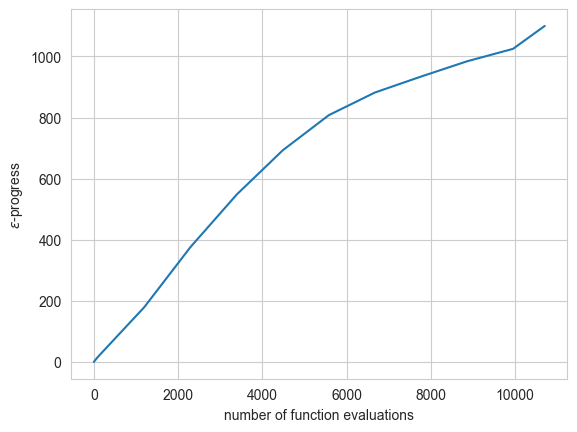

In [17]:
import matplotlib.pyplot as plt
import numpy as np
archive, convergence = total
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [0]:
from ema_workbench import save_results
archive, convergence = total
save_results(total, 'MORDM_10000_0.25_pf2.tar.gz'.format(nfe))

In [22]:

convergence.to_csv('data/MORDM_10000_0.25_pf2_convergence.csv')
archive.to_csv('data/MORDM_10000_0.25_pf2_archive.csv')


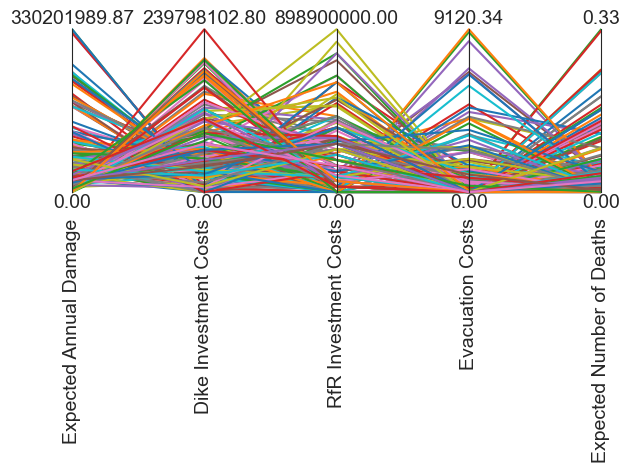

In [24]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

## Re-evaluate candidate solutions under uncertainty
The optimization resulted in a large number of candidate solutions. These need to be re-evaluated under uncertainty. Therefore, 100 scenarios are explored per scenario. Exploring over more scenarios results in computational costs that are too high. 

Since the one of the main objectives of Rijkswaterstaat is safety, an extra constraint is set. A policy with an average expected number of deaths higher than 0.001 is not acceptable. Therefore, another constraint is added. This also reduces the number of policies that needs to be re-evaluated and thus the computational costs.


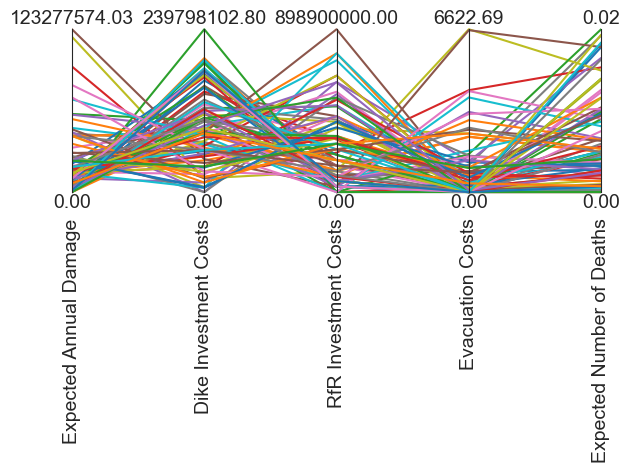

In [25]:
from ema_workbench.analysis import parcoords

archive_subspace = archive.loc[archive['Expected Number of Deaths'] < archive['Expected Number of Deaths'].median()]

data = archive_subspace.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [11]:
archive = pd.read_csv('MORDM_10000_0.25_pf2_archive.csv')
archive_subspace = archive.loc[archive['Expected Number of Deaths'] < archive['Expected Number of Deaths'].median()]
convergence = pd.read_csv('MORDM_10000_0.25_pf2_convergence.csv')

In [12]:
len(archive_subspace)

93

In [13]:
policies = archive_subspace
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,1,1,0,...,0,0,4,0,2,0,7,4,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,6,0,0,5,6,6,5,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,4,1,0,1,1,1,3,0,0
4,4,0,1,0,0,0,0,1,1,1,...,0,1,1,0,3,7,0,6,0,0
6,6,0,0,0,0,0,0,0,1,0,...,0,4,0,0,7,1,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,177,1,0,0,0,0,0,1,1,1,...,0,6,0,0,2,7,0,6,0,0
180,180,0,1,0,0,0,0,1,1,0,...,0,1,0,0,3,0,0,4,0,0
181,181,0,0,0,0,0,0,1,0,1,...,0,7,0,0,2,2,0,7,0,0
182,182,0,1,0,0,0,0,1,1,1,...,0,0,0,0,2,2,0,4,0,0


In [14]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

Now the constraint is set, the policies can be re-evaluated over the 1000 scenarios.

In [15]:
from ema_workbench import SequentialEvaluator

n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)


100%|██████████████████████████████████| 93000/93000 [7:31:00<00:00,  3.44it/s]


In [1]:
from ema_workbench import save_results
save_results(results, 'MORDM_1000_scen_nfe10000_0.25.tar.gz'.format(nfe))



NameError: name 'results' is not defined

In [23]:
experiments, outcomes = results
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df['policy'] = experiments['policy']
experiments.to_csv('data/MORDM_10000_0.25_pf2_scen1000_experiments.csv')
outcomes_df.to_csv('data/MORDM_10000_0.25_pf2_scen1000_outcomes.csv')

## Scenario Discovery (selection of 5 scenarios for multi-scenario MORDM)

### worst case scenarios

In [4]:
from ema_workbench import load_results

results = load_results('MORDM_1000_scen_nfe10000_0.25.tar.gz')
experiments, outcomes = results

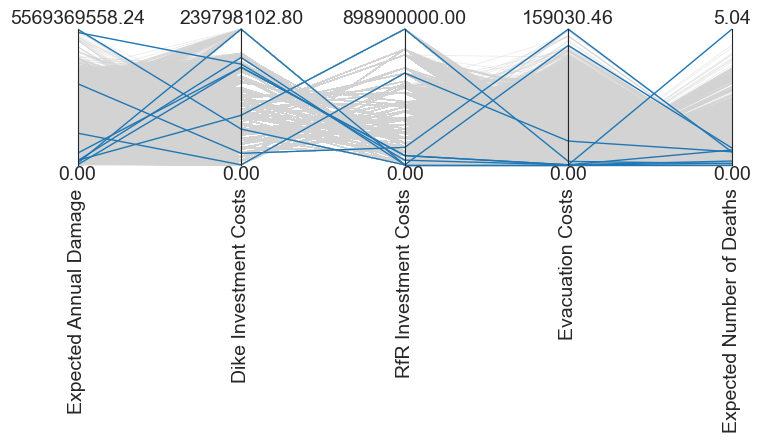

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

# conditional on y
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)
#axes.invert_axis('max_P')

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

In [6]:
print(all_data.idxmax())
print(all_data.idxmin())

Expected Annual Damage       66407
Dike Investment Costs        52000
RfR Investment Costs         45000
Evacuation Costs             28846
Expected Number of Deaths    86407
dtype: int64
Expected Annual Damage          81
Dike Investment Costs        24000
RfR Investment Costs          2000
Evacuation Costs                 0
Expected Number of Deaths       81
dtype: int64


In [7]:
# also all we need are the uncertainty columns
selected = experiments.loc[[66407, 52000, 45000, 28846, 86407], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
66407,124,314.400203,1.0,0.203345,315.901903,1.5,0.151716,221.445269,1.5,0.006179,154.539650,10.0,0.568681,335.326317,1.0,0.055939,4.5,1.5,1.5
52000,99,76.575130,1.0,0.523442,310.952861,10.0,0.100802,334.787144,1.0,0.078870,172.968460,1.0,0.643187,236.484828,10.0,0.339104,1.5,2.5,1.5
45000,99,76.575130,1.0,0.523442,310.952861,10.0,0.100802,334.787144,1.0,0.078870,172.968460,1.0,0.643187,236.484828,10.0,0.339104,1.5,2.5,1.5
28846,24,169.528991,1.0,0.419505,249.610738,10.0,0.038312,289.853217,1.5,0.019409,144.907506,1.0,0.880484,247.959228,10.0,0.694520,2.5,1.5,2.5
86407,124,314.400203,1.0,0.203345,315.901903,1.5,0.151716,221.445269,1.5,0.006179,154.539650,10.0,0.568681,335.326317,1.0,0.055939,4.5,1.5,1.5


In [8]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
scenarios

[Scenario({'A.0_ID flood wave shape': 124.0, 'A.1_Bmax': 314.4002028447528, 'A.1_Brate': 1.0, 'A.1_pfail': 0.2033447499894587, 'A.2_Bmax': 315.9019028751663, 'A.2_Brate': 1.5, 'A.2_pfail': 0.1517155795651275, 'A.3_Bmax': 221.4452687589414, 'A.3_Brate': 1.5, 'A.3_pfail': 0.0061792096004361, 'A.4_Bmax': 154.539650353164, 'A.4_Brate': 10.0, 'A.4_pfail': 0.568681083469557, 'A.5_Bmax': 335.3263166681378, 'A.5_Brate': 1.0, 'A.5_pfail': 0.0559391889218384, 'discount rate 0': 4.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5}),
 Scenario({'A.0_ID flood wave shape': 99.0, 'A.1_Bmax': 76.5751304155243, 'A.1_Brate': 1.0, 'A.1_pfail': 0.5234420322496701, 'A.2_Bmax': 310.95286100149747, 'A.2_Brate': 10.0, 'A.2_pfail': 0.1008020491568245, 'A.3_Bmax': 334.7871437375114, 'A.3_Brate': 1.0, 'A.3_pfail': 0.0788696871333113, 'A.4_Bmax': 172.96845993734274, 'A.4_Brate': 1.0, 'A.4_pfail': 0.6431869600263594, 'A.5_Bmax': 236.48482755032444, 'A.5_Brate': 10.0, 'A.5_pfail': 0.3391042179118312, 'discount rate

In [ ]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

## Multi-Scenario Multi-Objective MORDM

In [29]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []
    #problem = to_problem(model, searchover="levers")

    with MultiprocessingEvaluator(model) as evaluator:
        #for i in range(5): # random seeds cannot be done due to computing power limitations
        convergence_metrics = [
            #ArchiveLogger(
            #    "./data",
            #    [l.name for l in model.levers],
            #    [o.name for o in model.outcomes],
            #    base_filename=f"MORDM_0.25_{scenario.name}_seed_{i}.tar.gz",
            #),
            EpsilonProgress(),]

        result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        convergence=convergence_metrics,
                                        epsilons=epsilons,
                                        reference=scenario)

        results.append(result)
        convergences.append(convergence)

    # As no random seeds were used because of computing power, this step is not required and the results are returned directly
    #reference_set = epsilon_nondominated(results, epsilons, problem)

    #return reference_set, convergences
    return result, convergence

results = []
for scenario in scenarios:
    epsilons = [0.25,] * len(model.outcomes)
    results.append(optimize(scenario, 10, model, epsilons))


[MainProcess/INFO] pool started with 4 workers
100it [00:37,  2.67it/s]
[MainProcess/INFO] optimization completed, found 18 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 4 workers
100it [00:37,  2.69it/s]
[MainProcess/INFO] optimization completed, found 18 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 4 workers
100it [00:36,  2.71it/s]
[MainProcess/INFO] optimization completed, found 20 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 4 workers
100it [00:39,  2.55it/s]
[MainProcess/INFO] optimization completed, found 25 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 4 workers
100it [00:39,  2.51it/s]
[MainProcess/INFO] optimization completed, found 30 solutions
[MainProcess/INFO] terminating pool


In [32]:
from ema_workbench import save_results
for i in range(len(scenarios)):
    save_results(results[i], 'MSMORDM_results_10_025_pf2_scenario'+str(i)+'.tar.gz'.format(10*len(scenarios)))

ValueError: too many values to unpack (expected 2)

In [ ]:
from ema_workbench import load_results

results = load_results('MSMORDM_results_10000_0.25_pf2.tar.gz')
experiments, outcomes = results

In [36]:
archive, convergence = results

ValueError: too many values to unpack (expected 2)

In [40]:
experiments1, outcomes1 = results[0]

In [21]:
from platypus import Hypervolume
from ema_workbench.em_framework.optimization import rebuild_platypus_population


def calculate_convergence_metrics(problem, archives_file):
    hv = Hypervolume(minimum=[0, 0, 0, 0], maximum=[12, 3, 1, 1])
    archives = ArchiveLogger.load_archives(archives_file)
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(hypervolume=hv.calculate(population), nfe=nfe))

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)
    return metrics


problem = to_problem(model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenarios):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/MORDM_0.25_{scenario.name}_seed_{seed}.tar.gz"
        metrics = calculate_convergence_metrics(problem, archive_file)
        #metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress

        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

ValueError: No objects to concatenate

NameError: name 'convergence' is not defined

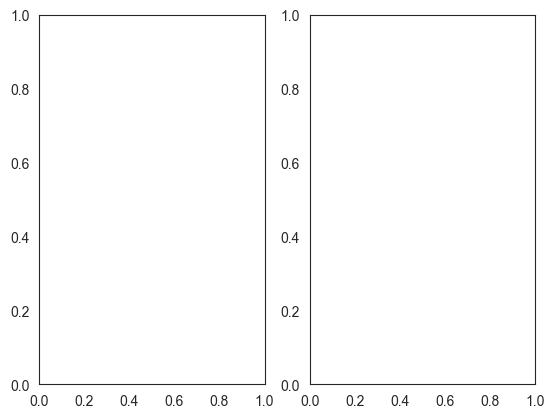

In [22]:
import matplotlib as mpl
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(ncols=2)

colors = sns.color_palette()

legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    # we use this for a custom legend
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax1.plot(score.nfe, score.hypervolume, c=color, lw=1)
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)


ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

# create our custom legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()

# Robustness metrics

Another important objective of Rijkswaterstaat is that policies should be robust. Therefore, the robustness of the differnt policies is calculated. For all policies the signal_to_noise ratio and the maximum regret is calculated. For both robustness metrics a function is created. 

**Signal-to-noise ratio**

In [17]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

In [20]:
from ema_workbench import ScalarOutcome
import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
model, planning_steps = get_model_for_problem_formulation(3)


experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
s_to_n_ = pd.DataFrame.from_dict(overall_scores).T
s_to_n_

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
1,1.488277e+01,0.000000e+00,1.243196e+16,1.296926e-04,6.585476e+14,4.654514e-07,8.428880e+13,7.602301e-10,2.688476e+15,2.541769e-06,0.0,4.878073e+07
8,2.194463e+17,8.477678e-02,4.719803e+15,1.030175e-03,5.063077e+15,1.376759e-03,8.519653e+13,1.163234e-07,3.208199e+14,4.215036e-06,0.0,0.000000e+00
11,3.166003e+13,3.491712e-10,9.127872e+14,7.386989e-06,1.913873e+16,4.250674e-02,2.794120e+14,1.493855e-05,2.734748e+15,9.710194e-04,0.0,0.000000e+00
13,4.234291e+00,0.000000e+00,7.080393e+15,4.214492e-04,2.196056e+16,6.398374e-02,8.279411e+14,9.302032e-05,3.017864e+15,3.544014e-04,0.0,0.000000e+00
14,2.648989e+17,1.355267e-02,9.630876e+15,2.365767e-04,2.262222e+16,4.182653e-03,6.459515e+14,8.211381e-06,4.891581e+14,2.089941e-07,0.0,2.871101e+07
17,6.518191e+16,3.255960e-04,2.142847e+16,2.288885e-04,7.415115e+15,3.460395e-05,4.606714e+14,1.650448e-07,6.238289e+14,6.110841e-08,0.0,1.128536e+08
20,3.093015e+17,1.919878e-03,7.972006e+15,7.776672e-06,1.727501e+16,3.578078e-04,3.492499e+13,6.703343e-11,9.279235e+15,4.221503e-05,0.0,1.361980e+08
21,4.527183e+16,8.292507e-05,1.645399e+16,9.233611e-05,2.193357e+16,5.549151e-04,3.131296e+14,1.696037e-07,4.867232e+15,5.360248e-05,0.0,1.752426e+08
33,9.076663e+00,0.000000e+00,6.120342e+15,8.066400e-06,1.806062e+16,7.514224e-04,3.126616e+14,4.744425e-07,4.170392e+15,1.085313e-05,0.0,9.423885e+07
84,9.879785e+14,5.697263e-06,1.511124e+16,1.006082e-04,2.685530e+16,5.725676e-04,3.601814e+13,5.906745e-10,1.925007e+15,4.463066e-06,0.0,1.013509e+08


In [23]:
from ema_workbench.analysis import parcoords

data = s_to_n_
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
#paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig('s_to_n parcoords')
plt.show()

NameError: name 's_to_n_' is not defined

Since we want to minimize all outcomes, a low signal-to-noise ratio is desired. 


**Maximum regret**

Regret is the difference between the performance of a policy in a specific scenario and the best possible performance of a policy in that scenario. The maximum regret is the maximum regret value of a policy across all scenarios. 
The lowest maximum regret values are desired since all outcomes are minimized. To avoid negative values, the absolute difference is calculated.

In [22]:
def calculate_regret(data, best):
    return np.abs(best-data)
    

The best possible performance in a specific scenario is calculated by using pandas. This code is based on the calculation of maximum regret in the code of assignment 8.
Source: https://github.com/quaquel/epa1361_open/blob/master/Week%205-6%20-%20robustness%20and%20direct%20search/assignment%208%20-%20model%20answer.ipynb

In [23]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\Lune\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


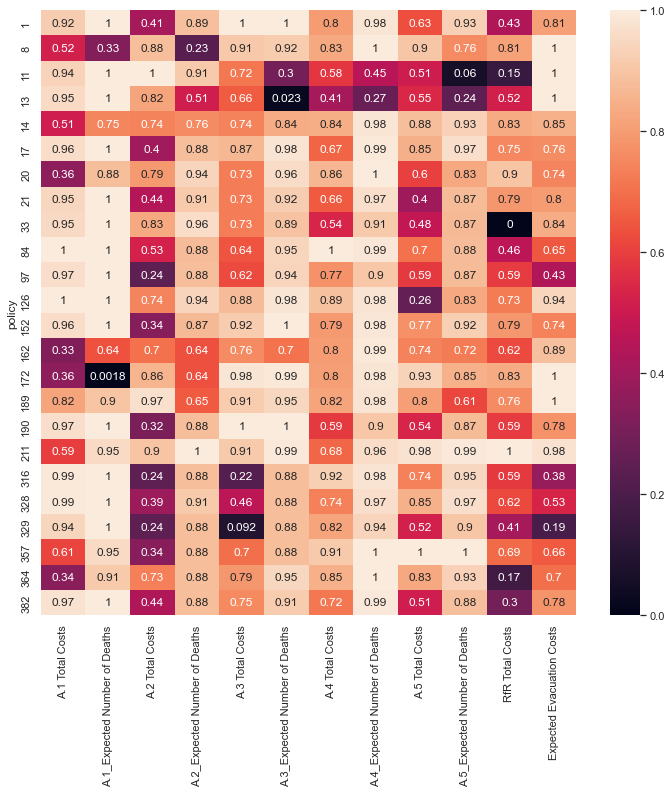

In [41]:
import seaborn as sns

max_regret = pd.DataFrame(max_regret)
plt.figure(figsize = (12,14))
sns.heatmap(max_regret/max_regret.max(), annot=True)
plt.subplots_adjust(bottom = 0.28)
#sns.set(rc={'figure.figuresize':(15,8)})
#fig.tight_layout()
#fig.set_size_inches(12,12)
plt.savefig('heatmap_regret')
plt.show()

In [25]:
max_regret

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,,,,,
1,2.876709e+09,1.497993,4.108905e+08,0.615332,2.235233e+09,2.776766,1.275697e+08,0.060489,5.768871e+08,0.593745,6.088000e+08,111519.257284
8,1.625710e+09,0.493766,8.805069e+08,0.157427,2.034869e+09,2.545938,1.327521e+08,0.061570,8.216262e+08,0.486323,1.147700e+09,138197.495996
11,2.923628e+09,1.497993,9.998534e+08,0.631772,1.601179e+09,0.833715,9.268623e+07,0.027925,4.626708e+08,0.038347,2.136000e+08,138197.495996
13,2.984321e+09,1.497993,8.192738e+08,0.356656,1.475083e+09,0.063799,6.567991e+07,0.016662,4.982459e+08,0.156755,7.300000e+08,138197.495996
14,1.596242e+09,1.123421,7.413995e+08,0.527615,1.658551e+09,2.322120,1.344940e+08,0.060512,8.031406e+08,0.597190,1.178400e+09,117169.656745
17,3.012448e+09,1.492952,4.005087e+08,0.612251,1.939820e+09,2.715355,1.076365e+08,0.061080,7.729692e+08,0.618962,1.063100e+09,105375.365212
20,1.123529e+09,1.318559,7.923808e+08,0.651939,1.633066e+09,2.662855,1.371839e+08,0.061570,5.474204e+08,0.532444,1.268900e+09,102802.135277
21,2.955922e+09,1.493805,4.418536e+08,0.633083,1.631433e+09,2.553963,1.046494e+08,0.059459,3.628191e+08,0.559211,1.111100e+09,110267.257530
33,2.974119e+09,1.497993,8.309563e+08,0.667106,1.633321e+09,2.473482,8.594388e+07,0.056062,4.355348e+08,0.556878,0.000000e+00,115970.970969


C:\Users\Lune\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Lune\Anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Lune\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if sys.path[0] == '':


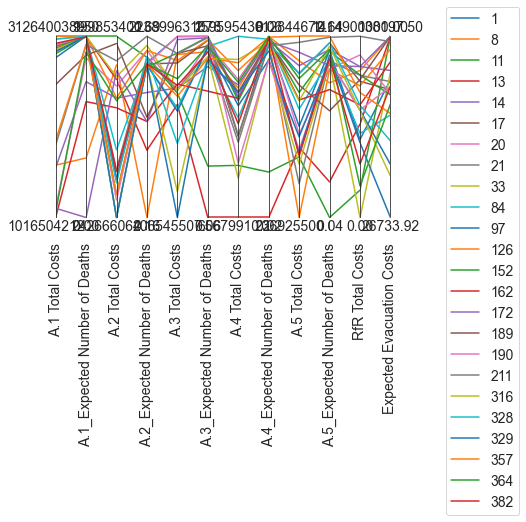

In [29]:
data = max_regret

colors = sns.color_palette(n_colors=len(data))

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.savefig('regret parcoords')
plt.show()